<a href="https://www.kaggle.com/code/hikmatullahmohammadi/playground-s3e1-california-house?scriptVersionId=115886110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Playground Series Season 3 Episode 1

**Table of contents:**<br>
- [1- Data exploration & preparation](#1)
- [2- Modeling](#2)
- [3- Prediction on the test set and submission](#3)


In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# input the dataset
df_train = pd.read_csv('/kaggle/input/playground-series-s3e1/train.csv', index_col=0)
df_test = pd.read_csv('/kaggle/input/playground-series-s3e1/test.csv', index_col=0)

<a id='1'></a>
## 1- Data exploration & preparation

In [3]:
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
id,,,,,,,,,
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [4]:
# the number of rows (observations) and columns (features)
df_train.shape

(37137, 9)

The dataset contains **37137** rows and **10** features including the *id* and the target variable which is **MedHouseVal**.

**Load and join the original dataset via sklearn. (California Housing)**

In [5]:
import sklearn.datasets as skl_ds
df_orig = skl_ds.fetch_california_housing()
df_orig = pd.DataFrame(data= np.c_[df_orig['data'], df_orig['target']],
                     columns= df_orig['feature_names'] + ['MedHouseVal'])
df_orig.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
## Let's join the two datasets (training and the original) as the training set
df_train = df_train.append(df_orig)
df_train.shape

(57777, 9)

In [7]:
# Combine the training and the test sets to do some data preprocessing
y = df_train.pop('MedHouseVal')
df = df_train.append(df_test)

---

In [8]:
# Missing values
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

No missing values in the dataset.

#### Handling outliers (Extreme values)

We use IQR approach to handle outliers

In [9]:
df_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000,57777.000000
mean,3.858046,26.979559,5.258104,1.074519,1576.720610,2.916770,35.592118,-119.559822
std,1.838287,12.374508,1.771502,0.294086,1249.494223,6.575793,2.102374,1.984615
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.588200,17.000000,4.381443,1.015306,882.000000,2.407625,33.930000,-121.800000
50%,3.521400,26.000000,5.126761,1.052941,1316.000000,2.769231,34.210000,-118.460000
75%,4.710900,36.000000,5.936031,1.091837,1815.000000,3.179673,37.700000,-118.020000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


From the above chart, we can see that *AveRooms*, *Population* and *AveOccup* features contain some outliers which will be taken care of later.<br>
Consider the figure bellow to visualize better the outliers.

Text(0.5, 1.0, 'AveRooms')

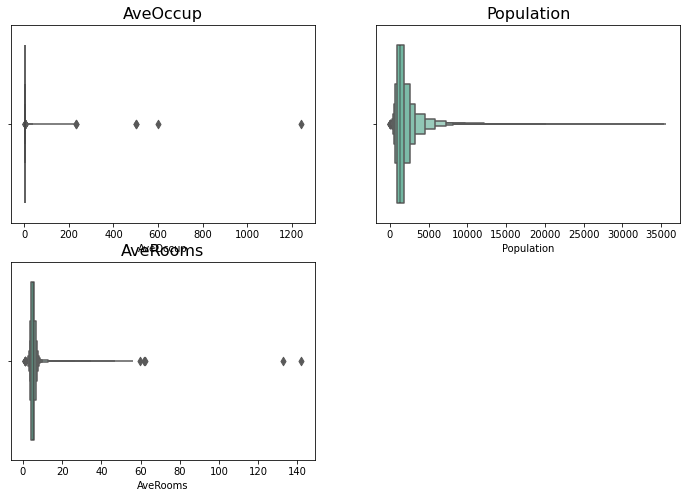

In [10]:
# Average Occupant
plt.figure(figsize=(12, 8))
sns.set_palette('Set2')

plt.subplot(2, 2, 1)
ax = sns.boxenplot(x=df['AveOccup'])
ax.set_title('AveOccup', fontdict={'fontsize':16})

# population
plt.subplot(2, 2, 2)
ax = sns.boxenplot(x=df['Population'])
ax.set_title('Population', fontdict={'fontsize':16})

# AveRooms
plt.subplot(2, 2, 3)
ax = sns.boxenplot(x=df['AveRooms'])
ax.set_title('AveRooms', fontdict={'fontsize':16})

Well, lets apply *IQR* to handle the outliers. In this case, we will replace them by their mean values.

In [11]:
# the function to replace outliers with nan
def replace_outliers_with_nan_iqr(df, feature, inplace=False):
    desired_feature = df[feature]
    
    q1, q3 = desired_feature.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    indices = (desired_feature[(desired_feature > upper_bound) | (desired_feature < lower_bound)]).index
    if not inplace:
        return desired_feature.replace(desired_feature[indices].values, np.nan)
    return desired_feature.replace(desired_feature[indices].values, np.nan, inplace=True)

In [12]:
# replace outliers by NaN in 'AveRooms', 'Population' and 'AveOccup' features
replace_outliers_with_nan_iqr(df, 'Population', inplace=True)
replace_outliers_with_nan_iqr(df, 'AveOccup', inplace=True)
replace_outliers_with_nan_iqr(df, 'AveRooms', inplace=True)

In [13]:
# number of values replaced by Nan
df['Population'].isnull().sum()

57484

In [14]:
# number of values replaced by Nan
df['AveOccup'].isnull().sum()

10813

In [15]:
# number of values replaced by Nan
df['AveRooms'].isnull().sum()

5444

In [16]:
# replace the NaN values of 'AveRooms', 'Population' and 'AveOccup' features with their mean values
df['Population'].fillna(value=df['Population'].mean(), inplace=True)
df['AveOccup'].fillna(value=df['AveOccup'].mean(), inplace=True)
df['AveRooms'].fillna(value=df['AveRooms'].mean(), inplace=True)

---

<a id='2'></a>
## 2- Modeling

Now, we will separate back the training and the test sets from each other.

In [17]:
df_train = df.iloc[:df_train.shape[0]]
df_test = df.iloc[df_train.shape[0]:]
df_train.shape

(57777, 8)

In [18]:
# split the trian and val data
from sklearn.model_selection import train_test_split

X = df_train
y = y

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=10)

In [19]:
# fit the dataset to the model
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [20]:
# make a prediction
y_pred = model.predict(X_val)

In [21]:
# Check the accuracy of the model
# RMSE
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_val, y_pred, squared=False)
print('RMSE: ', rmse)

RMSE:  0.5541612626215062


<a id='3'></a>
# 3- Prediction on the test set and submission

In [22]:
# do prediction on the test set
preds = model.predict(df_test)

In [23]:
submission = pd.DataFrame({
    'id': df_test.index,
    'MedHouseVal': preds
})

In [24]:
submission.to_csv('./submission.csv', index=False)

# Thank you :)